# Introduction

- There are two types of recommendation system
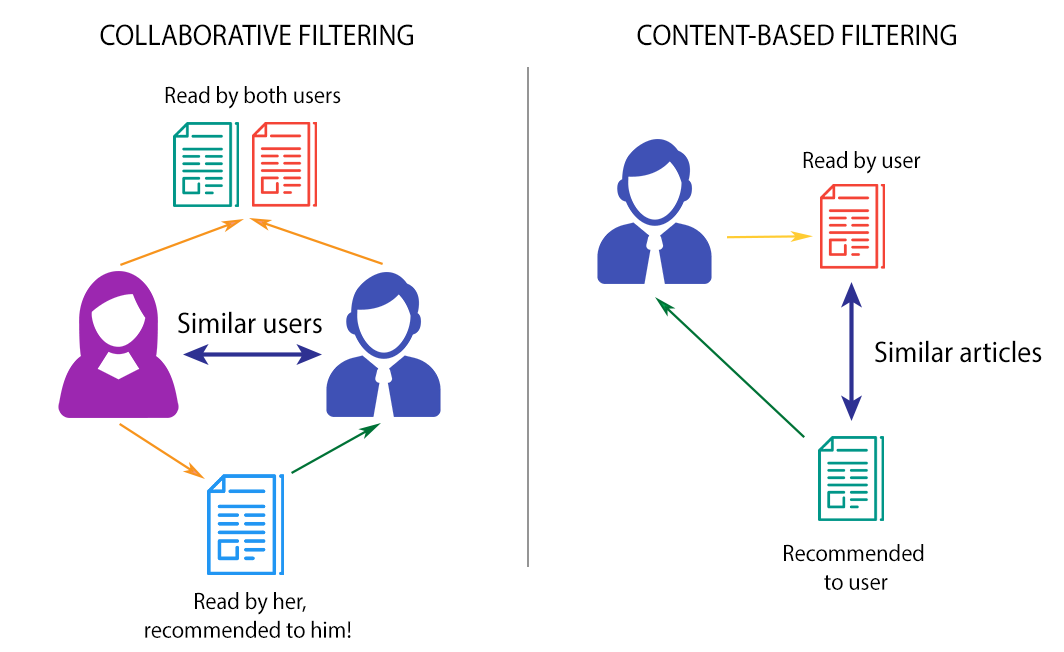

- **Content based approach** utilizes a series of discrete characteristics of an item in order to recommend additional items with similar properties.

- **Collaborative filtering approach** builds a model from a user’s past behaviors (items previously purchased or selected and/or numerical ratings given to those items) as well as similar decisions made by other users. This model is then used to predict items (or ratings for items) that the user may have an interest in.

# Importing Data and libraries

In [1]:
import numpy as np
import pandas as pd

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [2]:
movies_df = pd.read_csv('movies.csv',usecols=['movieId','title','genres'],dtype={'movieId': 'int32', 'title': 'str', 'genres':'str'})

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


- The genres alone can be used to provide a reasonably good content based recommendation

# Exploratory Data Analysis

In [4]:
movies_df.shape

(9742, 3)

In [5]:
movies_df.genres.str.split('|').explode()

0       Adventure
0       Animation
0        Children
0          Comedy
0         Fantasy
          ...    
9738      Fantasy
9739        Drama
9740       Action
9740    Animation
9741       Comedy
Name: genres, Length: 22084, dtype: object

## Which are the most popular genres?

In [6]:
genre_popularity = (movies_df.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
print(genre_popularity.head(10))

Drama        4361
Comedy       3756
Thriller     1894
Action       1828
Romance      1596
Adventure    1263
Crime        1199
Sci-Fi        980
Horror        978
Fantasy       779
Name: genres, dtype: int64


(-0.5, 999.5, 399.5, -0.5)

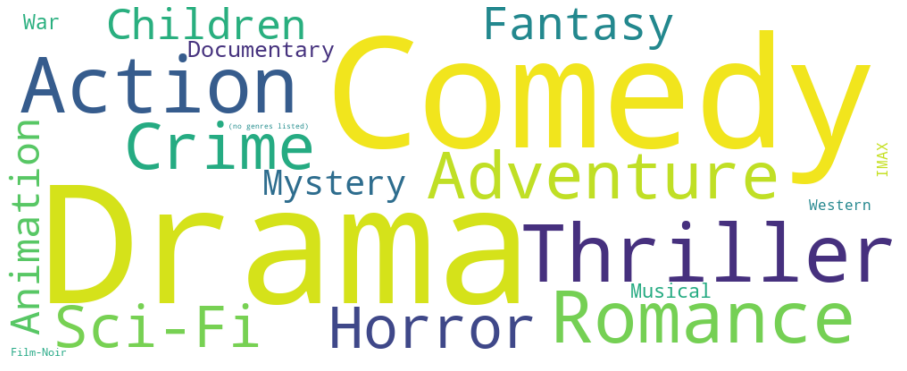

In [7]:
from wordcloud import WordCloud 
genre_wc = WordCloud(width=1000,height=400, background_color='white')
genre_wc.generate_from_frequencies(genre_popularity.to_dict())

plt.figure(figsize=(16, 8))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off')

- As we can see in movies_df_full, the most frequent genres are Drama, Comedy and Action, among others. We then have some other genres that are way less frequent such as Western, Fantasy or Sci-Fi. 

- These are the genres that we want to give the most importance to when recommending. 
- Why is that? As an example let's consider new user wants to find movies similar to Interstellar., which is a mixture of Sci-Fi, Drama, Mistery and Adventure. Say now that among the available movies to recommend we have a collection of Drama movies and some other Sci-Fi movies too. Which should we prioritise? In this case, it seems reasonable to assume that the less generic genre, Sci-Fi, will be the most relevant in terms of characterising the movie.

# TF-IDF
- This approach is more commonly used on a text corpus, it possesses some interesting properties that will be useful in order to obtain a vector representation of the data.
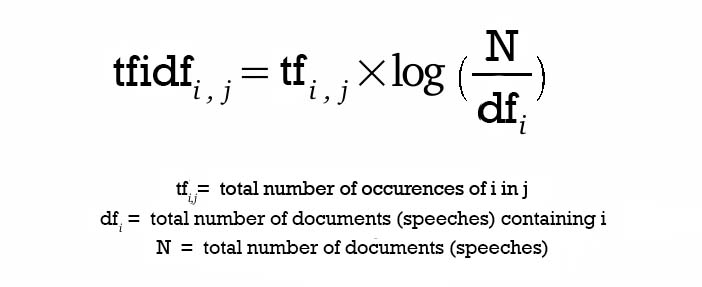
- Where we have the product of the term frequency, i.e. the amount of times a given term (genre) occurs in a document (genres of a movie), times the right side factor, which basically scales the term frequency depending on the amount of times a given term appears in all documents (movies).

- The lesser the amount of movies that contain a given genre (df_i), the higher the resulting weight. The logarithm is basically to smoothen the result of the division, i.e. avoids huge differences as a result of the right hand term.

- So why is this useful in our case?
    - As already mentioned, tf-idf will help capture the important genres of each movie by giving a higher weight to the less frequent genres, which we woulnd't get with say, CountVectorizer .

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import combinations

In [9]:
s = "Adventure Animation Children Comedy Fantasy"
tf_wrong = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
tf_wrong.fit([s])
tf_wrong.get_feature_names()

['adventure',
 'adventure animation',
 'animation',
 'animation children',
 'children',
 'children comedy',
 'comedy',
 'comedy fantasy',
 'fantasy']

However, that doesn't really make sense in this case, since the order of the genres is not relevant, we want to account for the combinations of genres for a given movie, regardless of the order. So for the example above, we'd want:

In [10]:
from itertools import combinations
[c for i in range(1,10) for c in combinations(s.split(), r=i)]

[('Adventure',),
 ('Animation',),
 ('Children',),
 ('Comedy',),
 ('Fantasy',),
 ('Adventure', 'Animation'),
 ('Adventure', 'Children'),
 ('Adventure', 'Comedy'),
 ('Adventure', 'Fantasy'),
 ('Animation', 'Children'),
 ('Animation', 'Comedy'),
 ('Animation', 'Fantasy'),
 ('Children', 'Comedy'),
 ('Children', 'Fantasy'),
 ('Comedy', 'Fantasy'),
 ('Adventure', 'Animation', 'Children'),
 ('Adventure', 'Animation', 'Comedy'),
 ('Adventure', 'Animation', 'Fantasy'),
 ('Adventure', 'Children', 'Comedy'),
 ('Adventure', 'Children', 'Fantasy'),
 ('Adventure', 'Comedy', 'Fantasy'),
 ('Animation', 'Children', 'Comedy'),
 ('Animation', 'Children', 'Fantasy'),
 ('Animation', 'Comedy', 'Fantasy'),
 ('Children', 'Comedy', 'Fantasy'),
 ('Adventure', 'Animation', 'Children', 'Comedy'),
 ('Adventure', 'Animation', 'Children', 'Fantasy'),
 ('Adventure', 'Animation', 'Comedy', 'Fantasy'),
 ('Adventure', 'Children', 'Comedy', 'Fantasy'),
 ('Animation', 'Children', 'Comedy', 'Fantasy'),
 ('Adventure', 'Anim

Here we're finding the sets of combinations of genres, or in mathematical terms, the superset. We can apply the above logic using the analyser parameter, which we can use to obtain the sequence of features from the raw input using a callable:

In [11]:
tfv = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,10) for c in combinations(s.split('|'), r=i)))

In [12]:
tfv_matrix = tfv.fit_transform(movies_df['genres'])

In [13]:
tfv_matrix.shape

(9742, 2946)

# Similarity between vectors

## Sigmoid Kernel

In [14]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

In [16]:
# Reverse mapping of indices and movie titles
indices = pd.Series(movies_df.index, index=movies_df.title).drop_duplicates()

In [17]:
indices[:10]

title
Toy Story (1995)                      0
Jumanji (1995)                        1
Grumpier Old Men (1995)               2
Waiting to Exhale (1995)              3
Father of the Bride Part II (1995)    4
Heat (1995)                           5
Sabrina (1995)                        6
Tom and Huck (1995)                   7
Sudden Death (1995)                   8
GoldenEye (1995)                      9
dtype: int64

In [18]:
indices['Amazing Spider-Man, The (2012)']

7927

In [19]:
sig[7927]

array([0.76159649, 0.76160003, 0.76159416, ..., 0.76159416, 0.76160146,
       0.76159416])

In [20]:
list(enumerate(sig[indices['Toy Story (1995)']]))

[(0, 0.7617366765880145),
 (1, 0.7616507832427931),
 (2, 0.7615981442230643),
 (3, 0.7615965015798539),
 (4, 0.7616040034923702),
 (5, 0.7615941559557649),
 (6, 0.7615981442230643),
 (7, 0.7616270380624358),
 (8, 0.7615941559557649),
 (9, 0.7615987919642004),
 (10, 0.7615965015798539),
 (11, 0.7615972287909091),
 (12, 0.7616504436899062),
 (13, 0.7615941559557649),
 (14, 0.7615980683203648),
 (15, 0.7615941559557649),
 (16, 0.7615941559557649),
 (17, 0.7616040034923702),
 (18, 0.7616040034923702),
 (19, 0.7615948465536608),
 (20, 0.7615959729605596),
 (21, 0.7615941559557649),
 (22, 0.7615941559557649),
 (23, 0.7615941559557649),
 (24, 0.7615941559557649),
 (25, 0.7615941559557649),
 (26, 0.7616040639231074),
 (27, 0.7615941559557649),
 (28, 0.7615999173819594),
 (29, 0.7615941559557649),
 (30, 0.7615941559557649),
 (31, 0.7615941559557649),
 (32, 0.7616040639231074),
 (33, 0.7615941559557649),
 (34, 0.7616243223533494),
 (35, 0.7615981442230643),
 (36, 0.7615941559557649),
 (37, 0.761

In [21]:
sorted(list(enumerate(sig[indices['Toy Story (1995)']])), key=lambda x: x[1], reverse=True)

[(0, 0.7617366765880145),
 (1706, 0.7617366765880145),
 (2355, 0.7617366765880145),
 (2809, 0.7617366765880145),
 (3000, 0.7617366765880145),
 (3568, 0.7617366765880145),
 (6194, 0.7617366765880145),
 (6486, 0.7617366765880145),
 (6948, 0.7617366765880145),
 (7760, 0.7617366765880145),
 (8219, 0.7617366765880145),
 (8927, 0.7617366765880145),
 (9430, 0.7617366765880145),
 (7184, 0.7616871494716365),
 (7917, 0.7616871494716365),
 (8273, 0.7616871494716365),
 (8674, 0.7616871494716365),
 (9536, 0.7616871494716365),
 (9560, 0.7616871494716365),
 (6915, 0.7616865111422139),
 (1505, 0.761686361041682),
 (1577, 0.761686361041682),
 (2539, 0.761686361041682),
 (3230, 0.761686361041682),
 (3336, 0.761686361041682),
 (4014, 0.761686361041682),
 (4424, 0.761686361041682),
 (5087, 0.761686361041682),
 (5624, 0.761686361041682),
 (5686, 0.761686361041682),
 (6944, 0.761686361041682),
 (9369, 0.761686361041682),
 (9544, 0.761686361041682),
 (1357, 0.7616836115804639),
 (5680, 0.7616836115804639),
 

In [22]:
def give_rec(title, sig=sig):
    # Get the index corresponding to original_title
    idx = indices[title]

    # Get the pairwsie similarity scores 
    sig_scores = list(enumerate(sig[idx]))

    # Sort the movies 
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:11]

    # Movie indices
    movie_indices = [i[0] for i in sig_scores]

    # Top 10 most similar movies
    return movies_df['title'].iloc[movie_indices]

In [23]:
give_rec('Toy Story (1995)')

1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
Name: title, dtype: object

In [24]:
movies_df[movies_df['title']=='Toy Story (1995)']

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [26]:
movies_df[movies_df['title']=='Antz (1998)']

,movieId,title,genres
1706,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy


In [27]:
give_rec('Amazing Spider-Man, The (2012)')

5260                           Spider-Man 2 (2004)
6238                       Superman Returns (2006)
7018                              Star Trek (2009)
7064    Transformers: Revenge of the Fallen (2009)
7212                                 Avatar (2009)
7484                           Tron: Legacy (2010)
7693                          Avengers, The (2012)
7842                            John Carter (2012)
7927                Amazing Spider-Man, The (2012)
8137                               Oblivion (2013)
Name: title, dtype: object

## Cosine 
- The next step will be to find similar vectors (movies). A commonly used measure is the cosine similarity.
- This similarity measure owns its name to the fact that it equals to the cosine of the angle between the two vectors being compared. The lower the angle between two vectors, the higher the cosine will be, hence yielding a higher similarity factor.
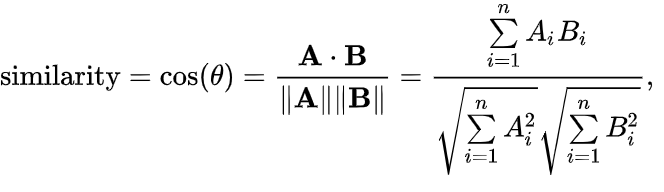

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfv_matrix, tfv_matrix)

In [ ]:
# Reverse mapping of indices and movie titles
indices = pd.Series(movies_df.index, index=movies_df.title).drop_duplicates()

In [31]:
def give_rec_cosine(title, cosine_sim=cosine_sim):
    # Get the index corresponding to original_title
    idx = indices[title]

    # Get the pairwsie similarity scores 
    cos_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies 
    cos_scores = sorted(cos_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    cos_scores = cos_scores[1:11]

    # Movie indices
    movie_indices = [i[0] for i in cos_scores]

    # Top 10 most similar movies
    return movies_df['title'].iloc[movie_indices]

In [32]:
give_rec_cosine('Toy Story (1995)')

1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
Name: title, dtype: object

In [33]:
give_rec_cosine('Amazing Spider-Man, The (2012)')

5260                           Spider-Man 2 (2004)
6238                       Superman Returns (2006)
7018                              Star Trek (2009)
7064    Transformers: Revenge of the Fallen (2009)
7212                                 Avatar (2009)
7484                           Tron: Legacy (2010)
7693                          Avengers, The (2012)
7842                            John Carter (2012)
7927                Amazing Spider-Man, The (2012)
8137                               Oblivion (2013)
Name: title, dtype: object